In [1]:
# 투수 EDA

%run ../data_tools.ipynb
%run ../create_metrics.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import xgboost
import shap

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from plotly.offline import plot
from plotly.offline import init_notebook_mode

init_notebook_mode(connected = True)


In [3]:
crawled_player_batter = pd.read_csv("../Crawler/crawled_player_batter.csv")
crawled_player_pitcher = pd.read_csv("../Crawler/crawled_player_pitcher.csv")
crawled_team_batter = pd.read_csv("../Crawler/crawled_team_batter.csv")
crawled_team_pitcher = pd.read_csv("../Crawler/crawled_team_pitcher.csv")
crawled_csum_player_pitcher = pd.read_csv("../Crawler/crawled_csum_player_pitcher.csv")

crawled_player_batter = crawled_player_batter.drop(["TB"], axis = "columns")
crawled_team_batter = crawled_team_batter.drop(["TB", "START_CK"], axis = "columns")
crawled_player_pitcher = crawled_player_pitcher.drop(["WHIP"], axis = "columns")
crawled_team_pitcher = crawled_team_pitcher.drop(["WHIP"], axis = "columns")
crawled_csum_player_pitcher = crawled_csum_player_pitcher.drop(["WHIP", "MONEY", "AGE_VA", "NAME"], axis = "columns")

In [4]:
total_data = []
for i in list(range(2016, 2021)) :
    rawData = load_data(i)
    Scaling_Money(rawData["player"])
    rawData["player_batter"] = pd.merge(rawData["player_batter"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    rawData["player_pitcher"] = pd.merge(rawData["player_pitcher"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    
    rawData["player_batter"] = rawData["player_batter"][crawled_player_batter.columns]
    rawData["player_pitcher"] = rawData["player_pitcher"][crawled_player_pitcher.columns]
    rawData["team_batter"] = rawData["team_batter"][crawled_team_batter.columns]
    rawData["team_pitcher"] = rawData["team_pitcher"][crawled_team_pitcher.columns]
    rawData["csum_player_pitcher"] = rawData["csum_player_pitcher"][crawled_csum_player_pitcher.columns]
    
    if i == 2020 :
        rawData["player_batter"] = pd.concat([rawData["player_batter"], crawled_player_batter]).reset_index(drop = True)
        rawData["player_pitcher"] = pd.concat([rawData["player_pitcher"], crawled_player_pitcher]).reset_index(drop = True)
        rawData["team_batter"] = pd.concat([rawData["team_batter"], crawled_team_batter]).reset_index(drop = True)
        rawData["team_pitcher"] = pd.concat([rawData["team_pitcher"], crawled_team_pitcher]).reset_index(drop = True)
        rawData["csum_player_pitcher"] = pd.concat([rawData["csum_player_pitcher"], crawled_csum_player_pitcher]).reset_index(drop = True)
        
    make_batter_metrics(rawData, "player_batter")
    make_batter_metrics(rawData, "team_batter")
    make_pitcher_metrics(rawData, "player_pitcher")
    make_pitcher_metrics(rawData, "team_pitcher")
    total_data.append(rawData)

tableList = []
for key in total_data[0].keys() :
    tableList.append(key)

final_data = dict()
for key in tableList :
    final_data[key] = pd.DataFrame()

for year in range(len(total_data)) :
    for key in tableList :
        if final_data[key].empty :
            final_data[key] = total_data[year][key]
        else :
            final_data[key] = pd.concat([final_data[key], total_data[year][key]], axis = 0)
            
for key in final_data.keys() :
    final_data[key].reset_index(drop = True)

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning:

In [5]:
# 세이버 메트릭스 대부분의 지표는 선수 개인을 대상으로 합니다.
# 예측은 팀 단위로 이루어지기 때문에 선수 데이터를 바탕으로 팀을 대표할 수 있도록
# 각 선수의 세이버 메트릭스 지표에 대해 타자의 경우 타석 수, 투수의 경우 이닝 수를 기준으로
# 경기 별 각 선수의 가중 평균을 해당 경기의 팀 스탯으로 나타냈습니다.

final_data["player_pitcher"].rename(columns = {"MONEY" : "MONEY_PIT", "AGE_VA" : "AGE_VA_PIT"}, inplace = True)
final_data["player_pitcher"] = final_data["player_pitcher"].reset_index(drop = True)

metrics_pitcher = ["BB/9", "LOB%", "FIP", "DER", "ERC", "ERA", "WHIP", "RA/9", "MONEY_PIT", "AGE_VA_PIT"]
final_data["player_pitcher"].sort_values(by = ["T_ID", "GDAY_DS", "HEADER_NO"])
final_data["player_pitcher"] = final_data["player_pitcher"].reset_index(drop = True)

result = final_data["player_pitcher"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"])["INN2"].sum()
result = result.to_frame().dropna().reset_index()
result.rename(columns = {"INN2" : "INN2_SUM"}, inplace = True)
result

final_data["team_pitcher"] = pd.get_dummies(final_data["team_pitcher"], columns = ["WLS"], drop_first = True)

final_data["player_pitcher"] = pd.merge(final_data["player_pitcher"], result)
final_data["player_pitcher"][metrics_pitcher] = final_data["player_pitcher"][metrics_pitcher].mul((final_data["player_pitcher"]["INN2"] / final_data["player_pitcher"]["INN2_SUM"]), axis = 0)
final_data["player_pitcher"] = final_data["player_pitcher"].drop("INN2_SUM", axis = "columns")
final_data["player_pitcher"] = final_data["player_pitcher"][final_data["player_pitcher"]["INN2"] != 0]
final_data["player_pitcher"] = final_data["player_pitcher"][~np.isinf(final_data["player_pitcher"]["LOB%"])]
final_data["player_pitcher"]

,GDAY_DS,START_CK,INN2,R,ER,PA,AB,HIT,H2,H3,...,K/9,BB/9,LOB%,FIP,WHIP,RA/9,DER,ERC,ERA,PPF
0,20160401,0,6.0,0.0,0.0,8.0,7.0,1.0,0.0,0.0,...,1.500000,0.083333,0.166667,-0.202297,0.166667,0.000000,0.125000,-0.006595,0.000000,NaN
1,20160401,0,5.0,0.0,0.0,8.0,6.0,2.0,0.0,0.0,...,0.600000,0.083333,0.138889,0.123086,0.250000,0.000000,0.092593,0.112715,0.000000,0.876596
2,20160401,0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0.000000,0.000000,0.027778,0.010982,0.083333,0.000000,0.013889,0.104118,0.000000,0.906066
3,20160401,1,18.0,4.0,4.0,28.0,25.0,9.0,2.0,0.0,...,0.666667,0.083333,0.300000,-0.218992,0.833333,0.333333,0.304348,0.566746,0.333333,0.882331
4,20160401,0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,...,1.000000,0.000000,NaN,-0.145229,0.000000,0.000000,0.083333,-0.046667,0.000000,0.769309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30030,20200916,0,9.0,0.0,0.0,11.0,10.0,1.0,0.0,0.0,...,1.000000,0.111111,0.333333,-0.206499,0.222222,0.000000,0.285714,-0.074870,0.000000,NaN
30031,20200919,0,1.0,4.0,4.0,5.0,3.0,2.0,0.0,0.0,...,0.000000,0.125000,0.000000,0.768473,0.375000,0.500000,0.013889,0.695360,0.500000,NaN
30032,20200919,0,6.0,1.0,0.0,8.0,7.0,2.0,1.0,0.0,...,1.500000,0.125000,0.166667,-0.281073,0.375000,0.125000,0.125000,0.079289,0.000000,NaN
30033,20200919,1,15.0,2.0,1.0,19.0,17.0,4.0,0.0,0.0,...,0.200000,0.125000,0.375000,0.389252,0.625000,0.250000,0.477941,0.012582,0.125000,NaN


In [18]:
# 각 선수별 스탯의 가중평균으로 나타낸 팀 스탯을 별도로 저장했습니다.

pitcher = final_data["player_pitcher"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"]).sum()
pitcher.rename(columns = {"ERA" : "ERA_WEIGHTED"}, inplace = True)
pitcher = pitcher.drop(["START_CK", "PPF"], axis = "columns")
pitcher = pitcher.dropna(axis = 0).reset_index(inplace = False)

pitcher = pd.merge(pitcher, final_data["team_pitcher"][["GDAY_DS", "T_ID", "HEADER_NO", "PPF", "ERA", "WLS_W"]])
pitcher = pitcher.sort_values(by = ["T_ID", "GDAY_DS"]).reset_index(inplace = False, drop = True)
pitcher.describe()

,GDAY_DS,HEADER_NO,INN2,R,ER,PA,AB,HIT,H2,H3,...,LOB%,FIP,WHIP,RA/9,DER,ERC,ERA_WEIGHTED,PPF,ERA,WLS_W
count,6.536000e+03,6536.000000,6536.000000,6536.000000,6536.000000,6536.000000,6536.000000,6536.000000,6536.000000,6536.000000,...,6536.000000,6536.000000,6536.000000,6536.000000,6536.000000,6536.000000,6536.000000,6356.000000,6536.000000,6536.000000
mean,2.017995e+07,0.009333,26.599908,5.024327,4.600673,38.988984,34.493268,9.535496,1.675031,0.142595,...,0.691051,1.561996,1.454650,0.576998,0.710194,1.165755,0.528236,0.879826,0.536961,0.502448
std,1.376695e+04,0.122728,2.712908,3.525167,3.366648,5.698672,4.723117,3.738134,1.377920,0.381897,...,0.188802,2.043950,0.536657,0.420338,0.089349,1.109099,0.400540,0.089068,0.402279,0.500032
min,2.016040e+07,0.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,-0.191358,-2.871860,0.000000,0.000000,0.000000,-0.560000,0.000000,0.526465,0.000000,0.000000
25%,2.017051e+07,0.000000,25.750000,2.000000,2.000000,35.000000,32.000000,7.000000,1.000000,0.000000,...,0.567901,0.084486,1.111111,0.237692,0.650000,0.384647,0.222222,0.825735,0.222222,0.000000
50%,2.018061e+07,0.000000,27.000000,4.000000,4.000000,38.000000,34.000000,9.000000,1.000000,0.000000,...,0.691579,1.255417,1.375000,0.500000,0.712001,0.935418,0.444444,0.877714,0.444444,1.000000
75%,2.019071e+07,0.000000,27.000000,7.000000,6.000000,42.000000,37.000000,12.000000,2.000000,0.000000,...,0.809524,2.669682,1.777778,0.777778,0.771638,1.691292,0.750000,0.921667,0.750000,1.000000
max,2.020092e+07,2.000000,54.000000,26.000000,24.000000,87.000000,75.000000,29.000000,9.000000,3.000000,...,4.111111,36.339531,4.500000,4.500000,1.000000,21.232206,4.500000,1.851023,4.500000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205E355F648>,
      dtype=object)

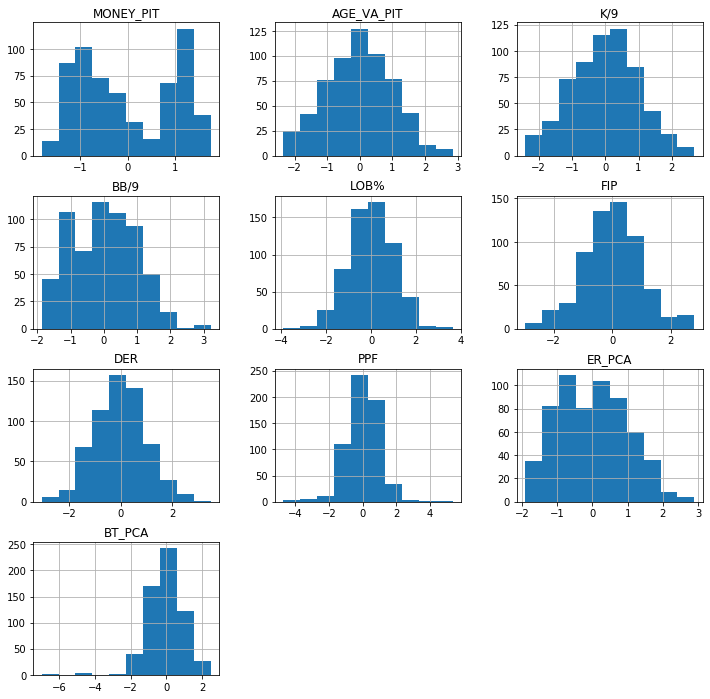

In [54]:
target = pitcher[pitcher["T_ID"] == "KT"].dropna().ERA[20:].reset_index(drop = True)

scaler = MinMaxScaler()
feature = pitcher[pitcher["T_ID"] == "KT"].dropna().drop(["GDAY_DS", "T_ID", "HEADER_NO", "H3", "IB", "BF", "H2", "HP", "WLS_W",
                                                         "BB", "KK", "INN2", "HR"], axis = "columns").reset_index(drop = True)

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["ERA", "R", "ER", "RA/9", "ERA_WEIGHTED", "WHIP", "ERC"]])
feature["ER_PCA"] = res
feature = feature.drop(["ERA", "R", "ER", "RA/9", "ERA_WEIGHTED", "WHIP", "ERC"], axis = "columns")

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["PA", "AB", "HIT"]])
feature["BT_PCA"] = res
feature = feature.drop(["PA", "AB", "HIT"], axis = "columns")

feature = pd.DataFrame(power_transform(feature, method = "yeo-johnson"), columns = feature.columns, index = feature.index.values)
feature = feature.loc[0:len(target)-1]
feature.hist(figsize = (12, 12))

In [55]:
feature.skew()

MONEY_PIT     0.150232
AGE_VA_PIT    0.002951
K/9          -0.009394
BB/9          0.028179
LOB%          0.000369
FIP           0.038667
DER           0.010501
PPF          -0.179006
ER_PCA        0.089553
BT_PCA       -0.882712
dtype: float64

In [56]:
feature.describe()

,MONEY_PIT,AGE_VA_PIT,K/9,BB/9,LOB%,FIP,DER,PPF,ER_PCA,BT_PCA
count,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000
mean,-0.011875,-0.014139,-0.002650,-0.002057,0.004129,0.005190,-0.015201,-0.000159,0.005119,-0.018227
std,1.004262,1.001293,0.988778,1.001290,1.010991,1.003686,1.005124,1.007457,0.999523,0.952954
min,-1.818219,-2.342572,-2.398785,-1.867932,-3.900968,-2.965999,-3.060171,-4.703532,-1.912228,-6.986323
25%,-0.911591,-0.707651,-0.676344,-0.803689,-0.689740,-0.611645,-0.715924,-0.589093,-0.749669,-0.580351
50%,-0.255644,0.007708,-0.011339,0.058822,0.020278,0.040531,0.028462,0.064422,-0.047297,-0.056338
75%,1.049664,0.738055,0.659451,0.735439,0.686432,0.632198,0.657594,0.572774,0.774130,0.571896
max,1.757251,2.847239,2.675807,3.212605,3.632883,2.800528,3.497347,5.339472,2.897662,2.490964


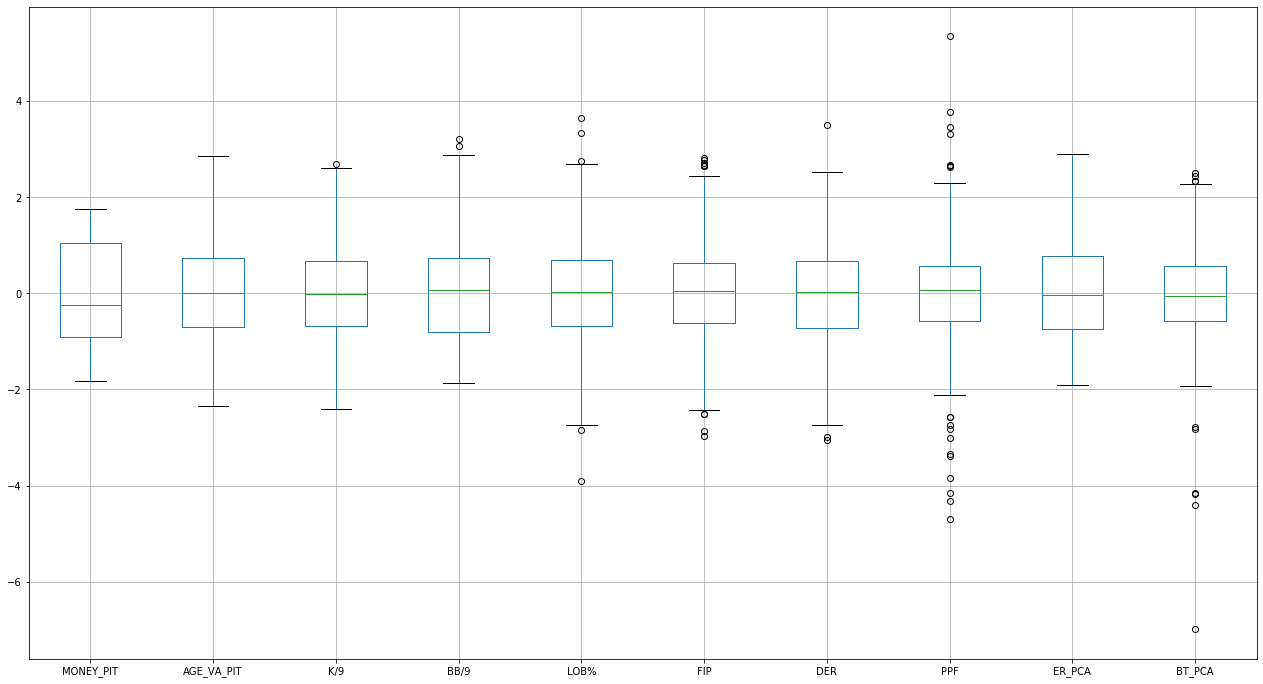

In [57]:
feature.boxplot(figsize = (22, 12))

In [58]:
feature.corr(method = "pearson")

,MONEY_PIT,AGE_VA_PIT,K/9,BB/9,LOB%,FIP,DER,PPF,ER_PCA,BT_PCA
MONEY_PIT,1.000000,0.719607,-0.052522,-0.169540,0.102937,-0.149498,0.023286,-0.040444,-0.150434,-0.074658
AGE_VA_PIT,0.719607,1.000000,-0.007904,-0.161408,0.061743,-0.082135,0.015803,-0.034071,-0.098590,-0.001498
K/9,-0.052522,-0.007904,1.000000,0.041314,-0.148376,-0.114393,-0.280886,0.070761,0.140429,0.259538
BB/9,-0.169540,-0.161408,0.041314,1.000000,-0.043371,0.479003,0.015360,0.014124,0.307093,0.178020
LOB%,0.102937,0.061743,-0.148376,-0.043371,1.000000,-0.137589,0.198902,0.004689,-0.544025,-0.184813
FIP,-0.149498,-0.082135,-0.114393,0.479003,-0.137589,1.000000,-0.028946,-0.021583,0.635449,0.349244
DER,0.023286,0.015803,-0.280886,0.015360,0.198902,-0.028946,1.000000,-0.007873,-0.536308,-0.595634
PPF,-0.040444,-0.034071,0.070761,0.014124,0.004689,-0.021583,-0.007873,1.000000,0.003963,-0.024889
ER_PCA,-0.150434,-0.098590,0.140429,0.307093,-0.544025,0.635449,-0.536308,0.003963,1.000000,0.677499
BT_PCA,-0.074658,-0.001498,0.259538,0.178020,-0.184813,0.349244,-0.595634,-0.024889,0.677499,1.000000


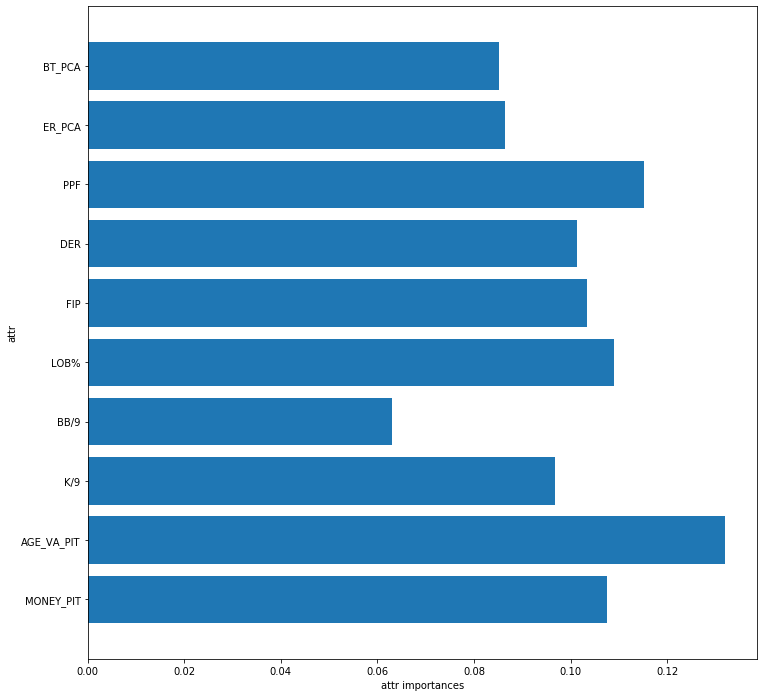

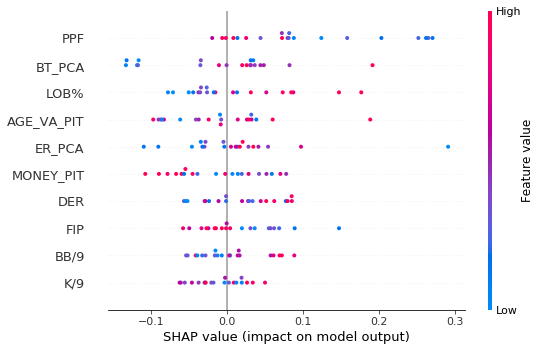

In [59]:
# Find Feature - GBRT
trainFeature = feature.loc[0:feature.shape[0]-20]
trainTarget = target.loc[0:feature.shape[0]-20]

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)

tree = GradientBoostingRegressor(max_depth = 5,learning_rate = 0.1, n_estimators = 500, subsample = 0.8)
tree.fit(trainFeature, trainTarget)

tree.score(testFeature, testTarget)


n_features = trainFeature.shape[1]

plt.figure(figsize = (12, 12))
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), testFeature.columns)
plt.xlabel("attr importances")
plt.ylabel("attr")
plt.ylim(-1, n_features)
plt.show()

explainer = shap.TreeExplainer(tree, trainFeature)
shap_values = explainer.shap_values(testFeature, check_additivity = False)
shap.summary_plot(shap_values, testFeature)


In [60]:
# Find Feature - GBRT

result = tree.predict(testFeature)
result = result.reshape(testTarget.shape[0])

result.mean()

0.6511431087511564

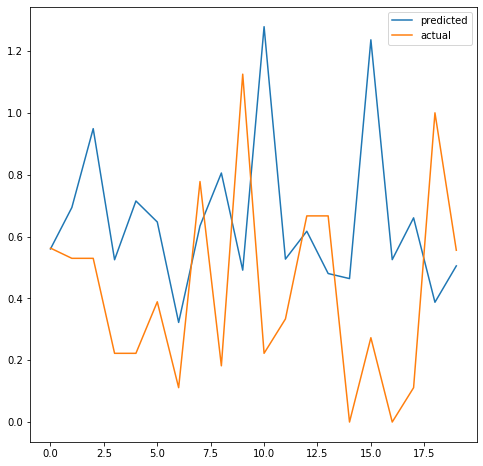

In [61]:

plt.figure(figsize = (8, 8))
plt.plot(result, label = "predicted")
plt.plot(testTarget, label = "actual")
plt.legend()
